### IMPORTING REQUIRED LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
#from pylab import rcParams
#rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = np.random.RandomState(42)
LABELS = ["Normal", "Fraud"]



### Importing Dataset

Content

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Link: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download

In [2]:
CCTransactions = pd.read_csv('creditcard.csv',sep=',')
CCTransactions.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
CCTransactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Exploratory Data Analysis

In [4]:
CCTransactions.isnull().values.any()

False

Normal Transactions :   284315  ==> 99.827  Percent 

Fraudulent Transactions :   492  ==> 0.173 Percent


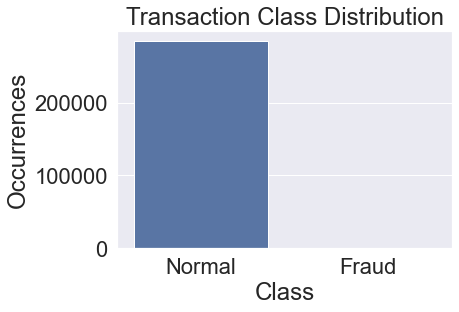

In [5]:
#Visualizing Class Distribution

Total_Transactions = CCTransactions['Class'].value_counts()[0] + CCTransactions['Class'].value_counts()[1]
Norm_per = (CCTransactions['Class'].value_counts()[0]/ Total_Transactions) * 100
Fraud_per = (CCTransactions['Class'].value_counts()[1]/ Total_Transactions) * 100

print("Normal Transactions :  ", CCTransactions['Class'].value_counts()[0], " ==>","%.3f" %Norm_per, " Percent \n")
print("Fraudulent Transactions :  ", CCTransactions['Class'].value_counts()[1], " ==>","%.3f" %Fraud_per, "Percent")


sns.set_theme(style="darkgrid")
sns.set(font_scale=2)
ax = sns.countplot(x="Class", data=CCTransactions)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Occurrences")
plt.show()

In [6]:
## Creating separate Dataframes for different Classes
Normal = CCTransactions[CCTransactions['Class']==0]


Fraud = CCTransactions[CCTransactions['Class']==1]


print("Normal Transactions : ", Normal.shape, "\n")
print("Fraudulent Transactions : ", Fraud.shape)

Normal Transactions :  (284315, 31) 

Fraudulent Transactions :  (492, 31)


In [7]:
## We need to analyze more amount of information from the transaction data
#How different are the amount of money used in different transaction classes?
Fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [8]:
Normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

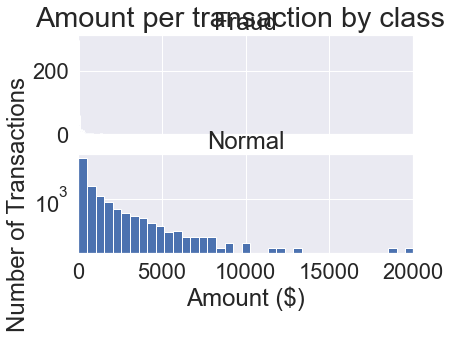

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(Fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(Normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

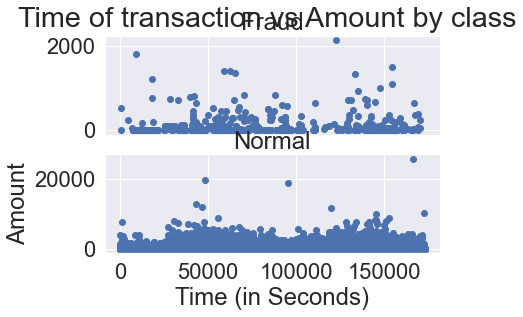

In [10]:
# We Will check Do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation.

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(Fraud.Time, Fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(Normal.Time, Normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [11]:
## Using Fraction of Data to Build our Model

Sample_df= CCTransactions.sample(frac = 0.1,random_state=RANDOM_SEED)

Sample_df.shape

(28481, 31)

In [12]:
# Determine the number of fraud and valid transactions in the dataset

Sample_Fraud = Sample_df[Sample_df['Class']==1]

Sample_Normal = Sample_df[Sample_df['Class']==0]

Contamination_Fraction = float("%.5f" %(len(Sample_Fraud)/float(len(Sample_Normal)+ len(Sample_Fraud))))

In [13]:
print("Contamination Fraction  :", Contamination_Fraction)

print("Fraud Cases       : {}".format(len(Sample_Fraud)))

print("Normal Cases      : {}".format(len(Sample_Normal)))

Contamination Fraction  : 0.00162
Fraud Cases       : 46
Normal Cases      : 28435


In [14]:
#Looking for top 10 correlated features

corr_matrix = Sample_df.corr()
corr_result= corr_matrix["Class"].sort_values(ascending=False).head(11)
corr_result

Class     1.000000
V11       0.157269
V4        0.132388
V2        0.079756
V21       0.052675
V19       0.049521
V20       0.024607
Amount    0.019044
V8        0.016033
V23       0.015739
V27       0.008926
Name: Class, dtype: float64

In [15]:
columns = Sample_df.columns.tolist()
columns

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'Class']

In [16]:

# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
columns

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount']

In [17]:
#Desired independent Features
Feature_name = []


for col in Sample_df.columns:
    if col != "Class":
        Feature_name.append(col)
    else:
        continue
        
# Desired Target Variable
Target_Name = "Class"

#Defining Independent and Dependent Variables
X = Sample_df[Feature_name]
y = Sample_df[Target_Name]


# Print the shapes of X & Y
print("Train :",X.shape)
print("Test :",y.shape)


Train : (28481, 30)
Test : (28481,)


### Model Prediction

In [18]:
#Define "Classifiers" to be used

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100,
                                       max_samples=len(X), 
                                       contamination=Contamination_Fraction,
                                       verbose=0,
                                       random_state=RANDOM_SEED),
    
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20,
                                              algorithm='auto', 
                                              leaf_size=30,
                                              metric='minkowski',
                                              p=2,
                                              metric_params=None,
                                              contamination=Contamination_Fraction),
    
     "Empirical Covariance":EllipticEnvelope(contamination= Contamination_Fraction,
                                             store_precision=True,
                                             assume_centered=False,
                                             support_fraction=0.8,
                                             random_state= RANDOM_SEED,
                                             ),
    
    "Support Vector Machine":OneClassSVM(kernel='rbf',
                                         degree=3,
                                         gamma=0.1,
                                         nu=0.05, 
                                         max_iter=-1)
   
}

In [21]:
import warnings
warnings.filterwarnings("ignore")

for i, (key,model) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    
    #Return the anomaly score of each sample using the IsolationForest algorithm

    if key== "Isolation Forest":
        model.fit(X)
        scores_prediction = model.decision_function(X)
        y_pred = model.predict(X)

        
    #Unsupervised Outlier Detection using Local Outlier Factor (LOF).    
    elif key == "Local Outlier Factor":
        y_pred = model.fit_predict(X)
        scores_prediction = model.negative_outlier_factor_
   
    #An object for detecting outliers in a Gaussian distributed dataset.
    elif key == "Empirical Covariance":
        model.fit(X)
        y_pred = model.predict(X)
     
    #Unsupervised Outlier Detection. Estimate the support of a high-dimensional distribution. The implementation is based on libsvm.
    elif key == "Support Vector Machine":
        model.fit(X)
        y_pred = model.predict(X)
    
    else:
        print("Model Does Not Exist")
        
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y).sum()
    
    # Run Classification Metrics
    print("{}: {}".format(key,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(y,y_pred))
    print("Classification Report :")
    print(classification_report(y,y_pred))

Isolation Forest: 61
Accuracy Score :
0.9978582212703205
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28435
           1       0.34      0.35      0.34        46

    accuracy                           1.00     28481
   macro avg       0.67      0.67      0.67     28481
weighted avg       1.00      1.00      1.00     28481

Local Outlier Factor: 91
Accuracy Score :
0.9968048874688389
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28435
           1       0.02      0.02      0.02        46

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481

Empirical Covariance: 71
Accuracy Score :
0.99750711000316
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.0

#Observations :
Isolation Forest detected 61 errors versus Local Outlier Factor detecting 91 errors vs. SVM detecting 9526 errors
Isolation Forest has a 99.7858% more accurate than LOF of 99.6804% and SVM of 70.09
When comparing error precision & recall for 3 models , the Isolation Forest performed much better than the LOF as we can see that the detection of fraud cases is around 27 % versus LOF detection rate of just 2 % and SVM of 0%.
So overall Isolation Forest Method performed much better in determining the fraud cases which is around 30%.
We can also improve on this accuracy by increasing the sample size or use deep learning algorithms however at the cost of computational expense.We can also use complex anomaly detection models to get better accuracy in determining more fraudulent cases